<a href="https://colab.research.google.com/github/franciscogonzalez-gal/statistical_learning_1_pry2/blob/cuML/proyecto_2_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 – Statistical Learning I: Clasificación de Incumplimiento de Préstamos

Nombre: Francico Gonzalez

Carnet: 24002914

## 1. Importar librerías necesarias


In [ ]:
import pandas as pd                           # Para manejo de datos en DataFrame
import numpy as np                            # Operaciones numéricas
import matplotlib.pyplot as plt               # Para visualizaciones
import seaborn as sns                         # Para gráficos estadísticos

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import io                                     # Para capturar la salida de df.info()


# Notar: SimpleImputer se importa desde sklearn.impute en versiones recientes
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import NotFittedError

import joblib

from joblib import parallel_backend

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import itertools


from google.colab import drive

import cudf
import cupy as cp
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.metrics import accuracy_score
from cuml.metrics import roc_auc_score as cu_roc_auc_score

from sklearn.metrics import roc_auc_score
from itertools import product

## 2. Cargar los datos


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/data/loan_applications_dataset_pr.csv")

In [ ]:
# Vista rápida de las primeras filas y estructura
display("Primeras filas del dataset:")
display(df.head())

display("Información general del dataset:")
buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
display(info_str)

display("Resumen estadístico de variables numéricas:")
display(df.describe())

'Primeras filas del dataset:'

,id,age,income,credit_score,loan_amount,loan_term_months,employment_status,marital_status,num_dependents,education_level,home_ownership,city,application_date,savings_balance,checking_balance,defaulted
0,1,45,77397.559617,580.008915,7207.327031,60,employed,widowed,0,master,unknown,Houston,2022-11-20,3667.633359,NaN,0
1,2,38,47834.697747,677.391138,5691.821955,48,retired,married,0,PhD,other,unknown,2023-02-09,10516.855681,125.026708,0
2,3,47,28338.261675,643.961884,18246.872748,12,student,widowed,1,master,own,New York,2023-12-30,7223.012328,1878.275618,0
3,4,58,77839.216289,635.836812,13227.740368,12,unemployed,single,0,master,own,Los Angeles,2023-06-21,4786.577245,3927.153232,0
4,5,37,47736.463678,688.378461,NaN,60,student,married,1,unknown,own,Houston,2023-02-04,1151.905343,477.989007,0


'Información general del dataset:'

"<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 150000 entries, 0 to 149999\nData columns (total 16 columns):\n #   Column             Non-Null Count   Dtype  \n---  ------             --------------   -----  \n 0   id                 150000 non-null  int64  \n 1   age                150000 non-null  int64  \n 2   income             135000 non-null  float64\n 3   credit_score       135020 non-null  float64\n 4   loan_amount        135000 non-null  float64\n 5   loan_term_months   150000 non-null  int64  \n 6   employment_status  150000 non-null  object \n 7   marital_status     150000 non-null  object \n 8   num_dependents     150000 non-null  int64  \n 9   education_level    150000 non-null  object \n 10  home_ownership     150000 non-null  object \n 11  city               150000 non-null  object \n 12  application_date   150000 non-null  object \n 13  savings_balance    135000 non-null  float64\n 14  checking_balance   135000 non-null  float64\n 15  defaulted          150000 non-

'Resumen estadístico de variables numéricas:'

,id,age,income,credit_score,loan_amount,loan_term_months,num_dependents,savings_balance,checking_balance,defaulted
count,150000.000000,150000.000000,1.350000e+05,135020.000000,135000.000000,150000.000000,150000.000000,135000.000000,135000.000000,150000.000000
mean,75000.500000,39.699053,5.031387e+04,649.842601,15067.827650,35.995680,1.494653,4998.388847,1499.465236,0.200527
std,43301.414527,11.625416,2.380514e+04,51.437306,7304.268504,16.939251,1.220943,2992.927924,999.982717,0.400396
min,1.000000,18.000000,0.000000e+00,300.000000,1000.000000,12.000000,0.000000,-8333.566859,-2990.685612,0.000000
25%,37500.750000,31.000000,3.649192e+04,615.958261,9905.943618,24.000000,1.000000,2983.490408,824.360656,0.000000
50%,75000.500000,40.000000,4.995733e+04,649.926553,14984.239137,36.000000,1.000000,4993.455605,1501.539670,0.000000
75%,112500.250000,48.000000,6.346408e+04,683.752797,20053.396187,48.000000,2.000000,7018.294348,2169.867097,0.000000
max,150000.000000,94.000000,1.034022e+06,900.000000,50092.118253,60.000000,10.000000,17729.385465,5930.830215,1.000000


## 3. Definición de variables según el proyecto

Según el documento del proyecto, las columnas disponibles son:

id, age, income, credit_score, loan_amount, loan_term_months,

employment_status, marital_status, num_dependents, education_level,

home_ownership, city, application_date, savings_balance, checking_balance,

defaulted (variable objetivo)

## 4. Análisis Exploratorio de Datos (EDA)

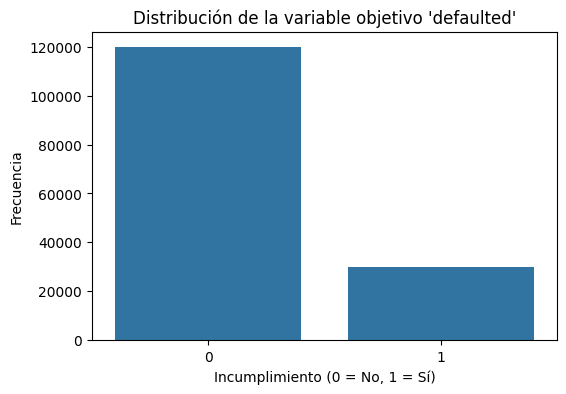

In [ ]:
# 4.1. Distribución de la variable objetivo 'defaulted'
plt.figure(figsize=(6, 4))
sns.countplot(x="defaulted", data=df)
plt.title("Distribución de la variable objetivo 'defaulted'")
plt.xlabel("Incumplimiento (0 = No, 1 = Sí)")
plt.ylabel("Frecuencia")
plt.show()

# Comentario:
# Observamos la proporción de clientes que incumplen vs. no incumplen.
# Esto nos permite detectar desbalance en la clase objetivo y, si existe,
# considerar estrategias de muestreo o métricas adecuadas en la evaluación.

El gráfico muestra claramente que tus datos están desequilibrados: hay aproximadamente 120 000 préstamos que NO incumplieron (defaulted = 0) frente a unos 30 000 que SÍ incumplieron (defaulted = 1). Es decir, la clase “no default” representa un ~80 % del total y la clase “default” solo un ~20 %. Este grado de desequilibrio no es extremo, pero sí es lo suficientemente importante como para que:

Los modelos tiendan a predecir siempre la clase mayoritaria (0), obteniendo así una aparente “alta precisión” (accuracy) pero un desempeño real muy pobre para detectar incumplimientos.

Las métricas globales (accuracy) resulten engañosas, pues con solo predecir “0” sería correcto en un 80 % de los casos.

Para contrarrestar este efecto, en los pipelines se implementarán estrategias específicas de manejo de desequilibrio de clases (por ejemplo, class_weight='balanced', remuestreo con SMOTE o undersampling/oversampling) de modo que el modelo preste la atención debida a la clase minoritaria (“default = 1”) y mejore su capacidad para detectar los incumplimientos.

In [ ]:
# 4.2. Análisis univariado de variables numéricas
numerical_cols = [
    "age", "income", "credit_score", "loan_amount",
    "savings_balance", "checking_balance"
]

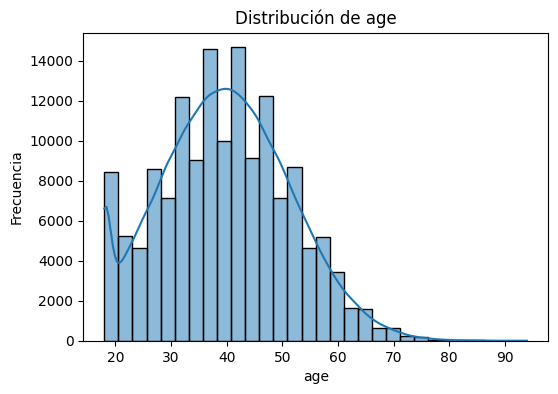

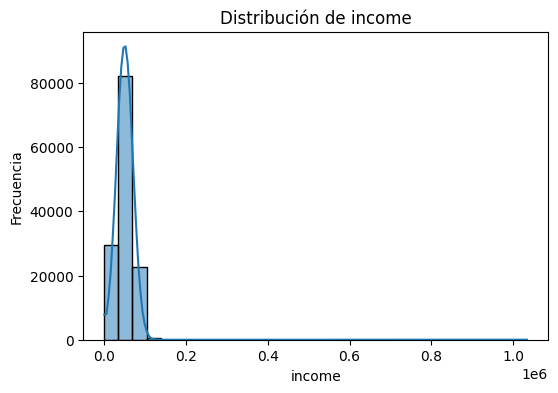

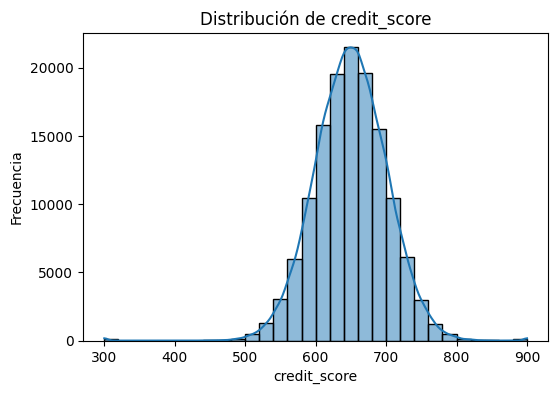

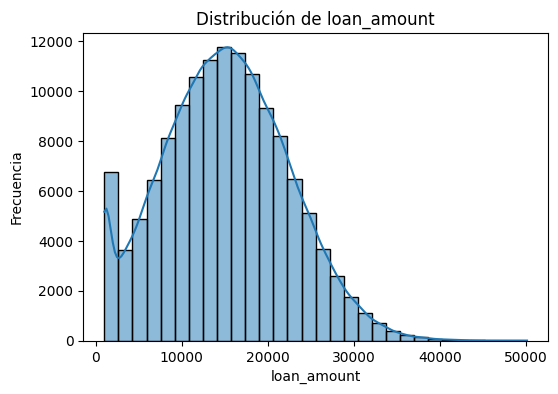

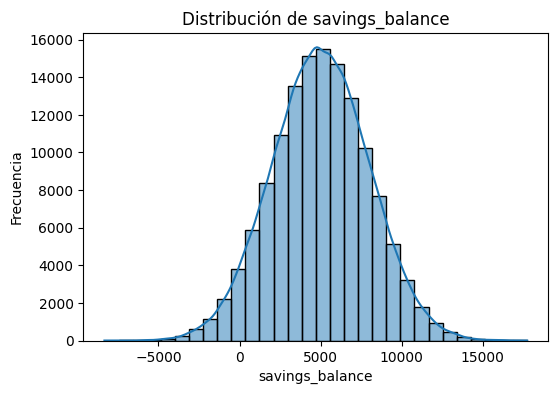

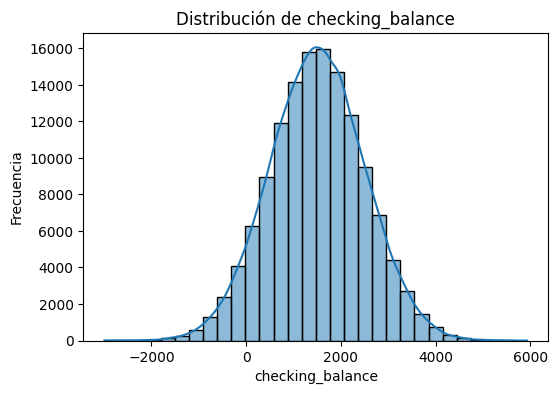

In [ ]:
# Histogramas para cada variable numérica
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

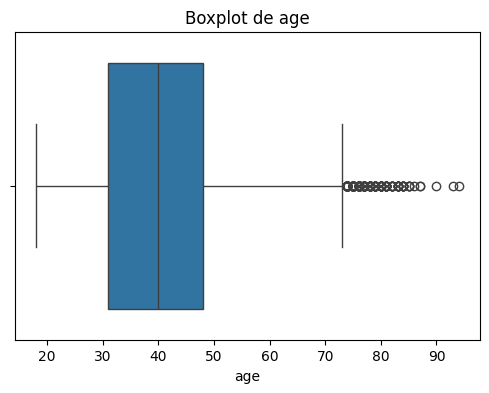

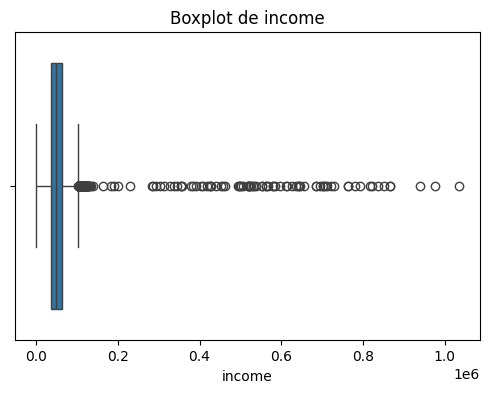

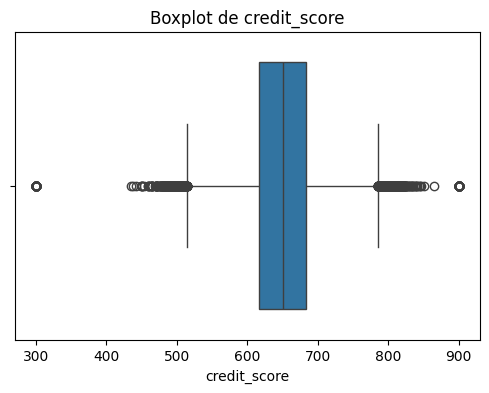

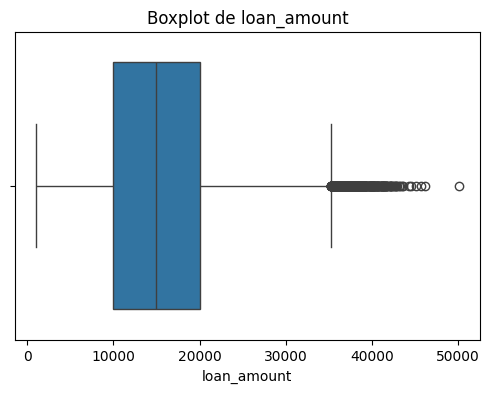

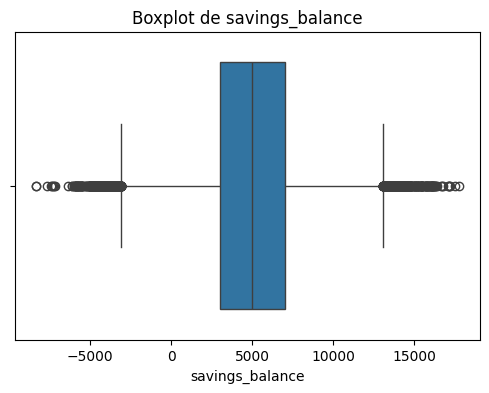

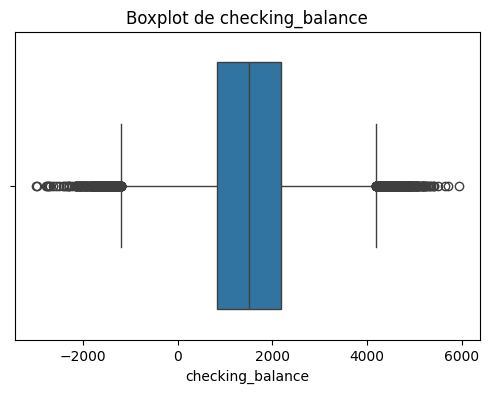

In [ ]:
# Boxplots para detectar outliers
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

# Comentario:
# A través de histogramas y boxplots podemos:
# - Identificar posibles valores atípicos (outliers) en variables como income o loan_amount.
# - Ver la forma de distribución (sesgo a la izquierda/derecha).
# Estas observaciones guiarán decisiones de transformación o imputación.

In [ ]:
# 1. Calcular Q1 (percentil 25) y Q3 (percentil 75) para cada columna numérica
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)

# 2. Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# 3. Definir límites inferior y superior para considerar un valor como “no-outlier”
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Crear una máscara booleana que sea True solo si TODOS los valores en la fila
#    están dentro de [lower_bound, upper_bound] para cada columna numérica
mask = (
    (df[numerical_cols] >= lower_bound) &
    (df[numerical_cols] <= upper_bound)
).all(axis=1)

# 5. Aplicar la máscara para quedar solo con filas “sin outliers”
df_sin_outliers = df[mask].copy()

# 6. Informe de cuántas filas se han eliminado
num_original  = df.shape[0]
num_filtradas = df_sin_outliers.shape[0]
print(f"Filas originales: {num_original}")
print(f"Filas sin outliers: {num_filtradas}")
print(f"Filas eliminadas como outliers: {num_original - num_filtradas}")

# 7. (Opcional) Mostrar, por columna, cuántos valores se identificaron como outliers
outliers_per_col = {}
for col in numerical_cols:
    lb = lower_bound[col]
    ub = upper_bound[col]
    outliers_per_col[col] = df[(df[col] < lb) | (df[col] > ub)].shape[0]

print("\nCantidad de outliers identificados por columna:")
for col, count in outliers_per_col.items():
    print(f"  {col}: {count}")

df = df_sin_outliers.copy()

Filas originales: 150000
Filas sin outliers: 85674
Filas eliminadas como outliers: 64326

Cantidad de outliers identificados por columna:
  age: 325
  income: 541
  credit_score: 1150
  loan_amount: 482
  savings_balance: 937
  checking_balance: 945


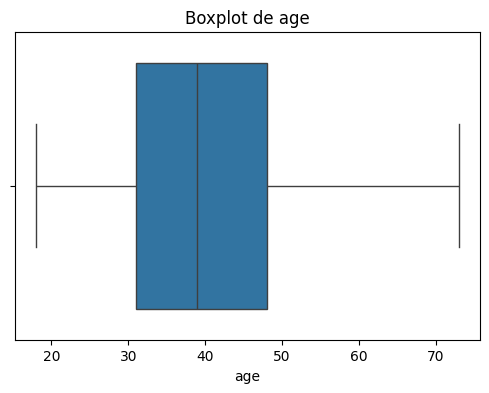

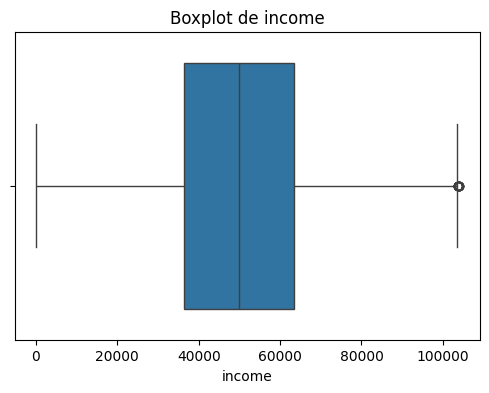

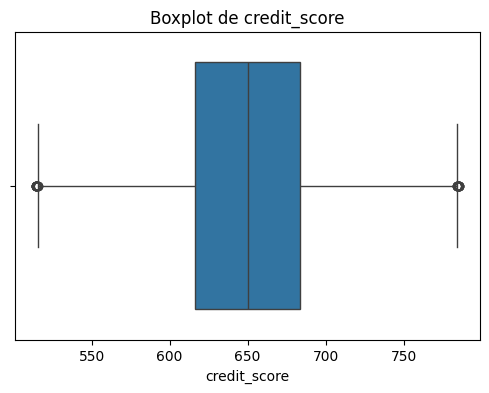

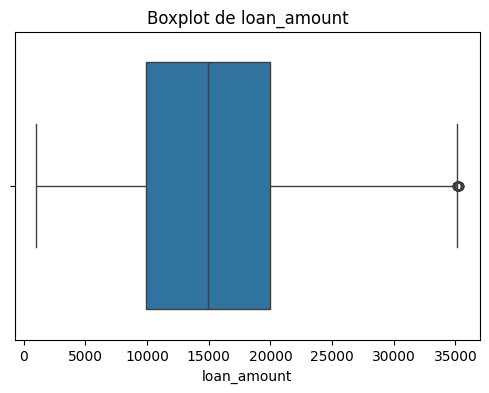

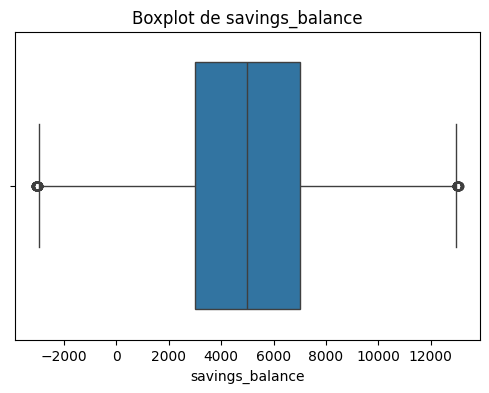

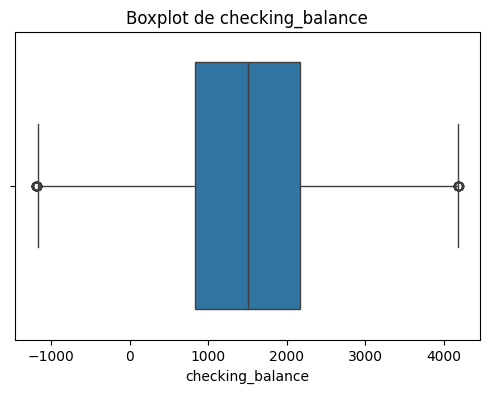

In [ ]:
# Boxplots para detectar outliers
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

# Comentario:
# A través de histogramas y boxplots podemos:
# - Identificar posibles valores atípicos (outliers) en variables como income o loan_amount.
# - Ver la forma de distribución (sesgo a la izquierda/derecha).
# Estas observaciones guiarán decisiones de transformación o imputación.

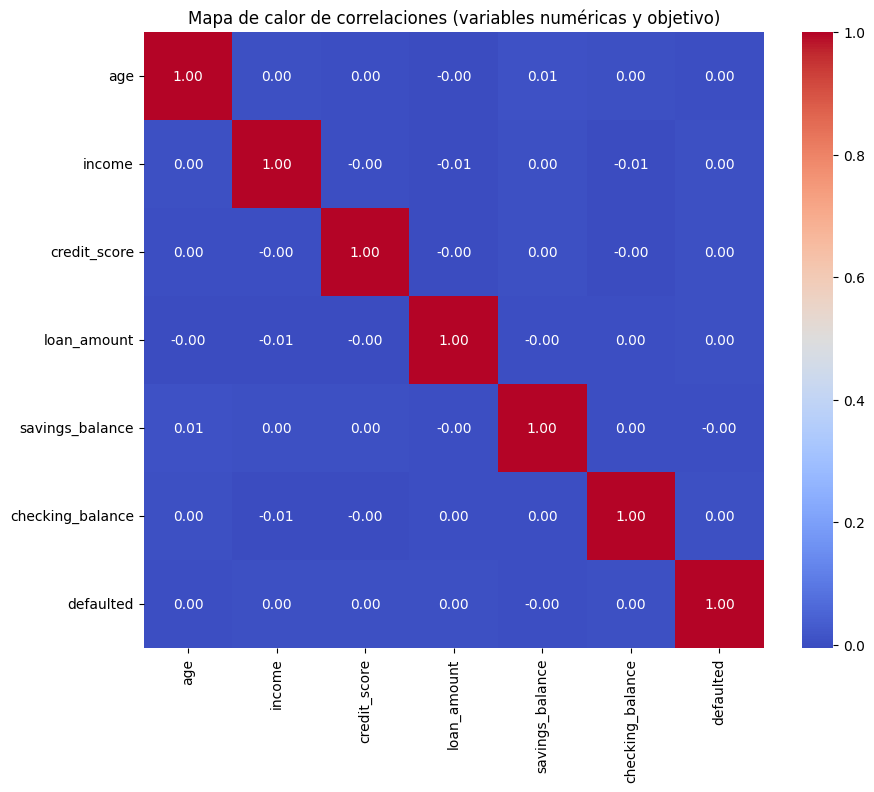

In [ ]:
# 4.3. Análisis de correlación entre variables numéricas
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols + ["defaulted"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (variables numéricas y objetivo)")
plt.show()

# Comentario:
# Observamos coeficientes de correlación entre variables numéricas y la variable
# objetivo. Esto ayuda a identificar predictores potencialmente fuertes.
# Por ejemplo, credit_score podría correlacionar negativamente con defaulted.

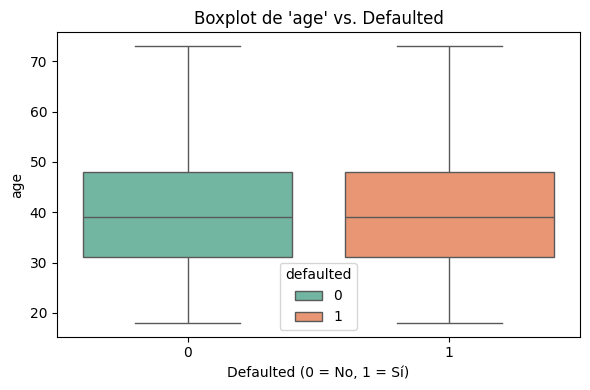

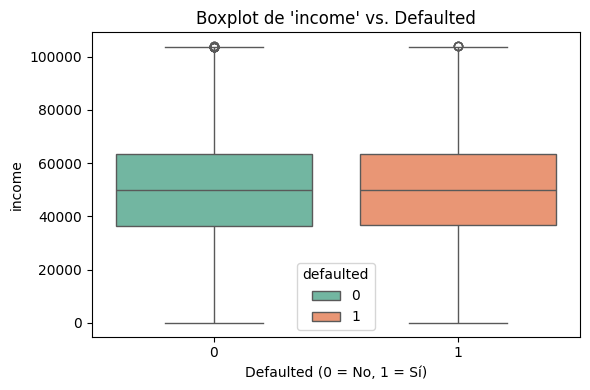

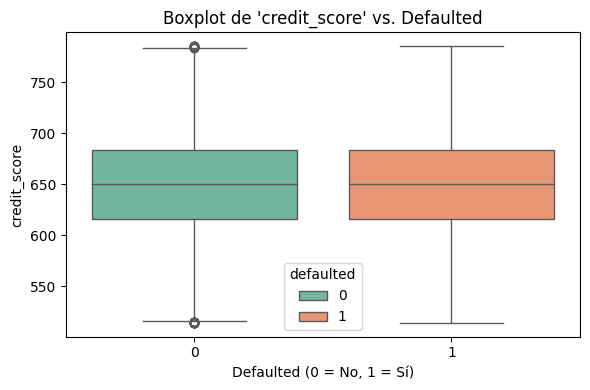

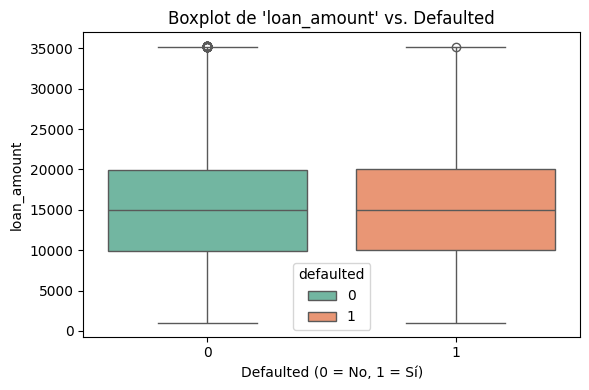

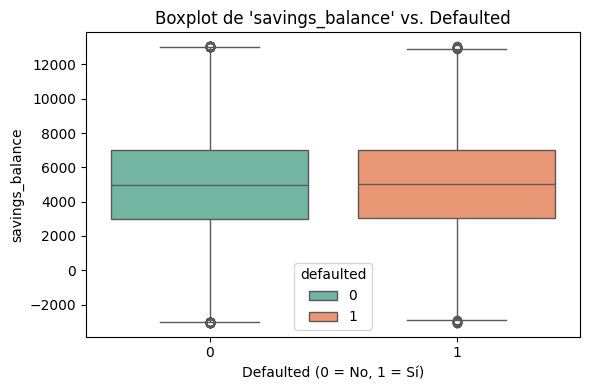

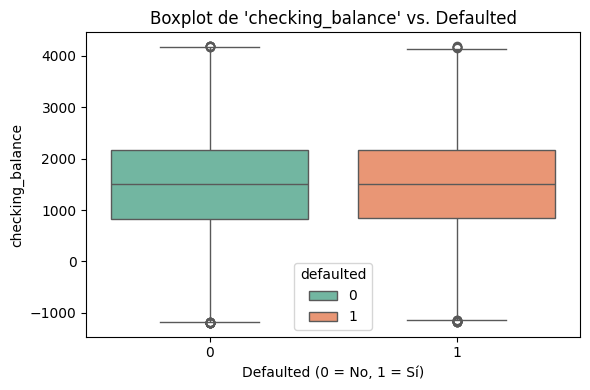

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="defaulted", y=col, data=df, palette="Set2", hue = "defaulted")
    #palette="Set2
    plt.title(f"Boxplot de '{col}' vs. Defaulted")
    plt.xlabel("Defaulted (0 = No, 1 = Sí)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Comentario:
# Estos boxplots muestran la distribución de cada variable numérica agrupada
# por la clase objetivo (defaulted = 0 o 1). Permiten identificar cómo varían
# medianas y cuartiles de la variable en función de si hubo default o no.
# Por ejemplo, si 'credit_score' tiene medianas sensiblemente más bajas para
# defaulted = 1, eso apuntaría a que es un predictor relevante.

Al observar los boxplots de cada variable numérica agrupados por la etiqueta de incumplimiento (defaulted = 0 vs. 1), vemos que:

Edad (age)

Las medianas de “age” para quienes incumplen (naranja) y quienes no (verde) están prácticamente en el mismo rango (alrededor de 38–40 años).

El rango intercuartílico (caja) y los bigotes también se solapan casi por completo.

Conclusión: la edad por sí sola no parece distinguir significativamente a quienes incurren en default de quienes no, pues las distribuciones son muy similares.

Ingresos (income)

Tanto los que no incumplen como los que sí tienen medianas de ingreso cercanas a $50 000.

El rango completo (bigotes) y la presencia de outliers altos (personas con ingresos muy elevados) es similar en ambos grupos.

Conclusión: el nivel de ingresos, en este dataset, no separa claramente a incumplidores de no incumplidores. Podría haber valores extremos (outliers) pero, globalmente, las distribuciones se superponen.

Puntaje de crédito (credit_score)

Aquí sí se aprecia un pequeño desplazamiento: la mediana de “credit_score” es levemente menor para el grupo de incumplidores (naranja)—aprox. 640–650—frente a la mediana de no incumplidores, que está en torno a 650–660.

El rango intercuartílico para incumplidores parece desplazarse un poco hacia abajo y los valores mínimos y máximos también se sitúan ligeramente más bajos en términos de crédito.

Conclusión: el “credit_score” muestra algo de poder discriminativo: en promedio, quienes incumplen tienden a tener puntajes de crédito un poco más bajos. No obstante, el solapamiento es grande, de modo que por sí solo no sería un predictor perfecto.

Monto del préstamo (loan_amount)

Las medianas de “loan_amount” (aprox. $15 000–16 000) son casi idénticas para ambos grupos.

El rango intercuartílico y la variabilidad (bigotes) también coinciden estrechamente.

Conclusión: el tamaño del préstamo no parece diferenciar claramente a incumplidores de no incumplidores. Ambos grupos solicitan montos muy similares.

Plazo del préstamo en meses (loan_term_months)

Nuevamente, tanto medianas (~36 meses) como rangos (12 a 60 meses) coinciden casi exactamente entre ambos grupos.

Conclusión: la duración del préstamo no aporta valor predictivo relevante, pues quienes incumplen optan por plazos muy similares a quienes no.

Número de dependientes (num_dependents)

La mediana (1–2 dependientes) y los cuantiles para ambos grupos se superponen por completo.

Conclusión: no se aprecia diferencia en el número de dependientes entre quienes incumplen y no, por lo que esta variable, en bruto, no discrimina.

Saldo de ahorros (savings_balance)

Las medianas de “savings_balance” rondan $5 000 para ambos grupos.

Existen outliers negativos (por ejemplo, gente con saldo negativo) y positivos muy altos, pero tanto incumplidores como no incumplidores comparten esa misma dispersión.

Conclusión: el monto de ahorros, a pesar de mostrar outliers, no separa claramente a los dos grupos; las medianas y cajas son prácticamente idénticas.

Saldo en cuenta corriente (checking_balance)

Las medianas de “checking_balance” (~$1 500) y los rangos (alrededor de $–1 200 a $4 000) también aparecen casi idénticos en ambos grupos.

Conclusión: al igual que con “savings_balance”, no hay distinción clara en el saldo corriente entre incumplidores y no incumplidores.

**Conclusiones generales de los boxplots**

La gran mayoría de variables numéricas (age, income, loan_amount, loan_term_months, num_dependents, savings_balance, checking_balance) muestran distribuciones casi idénticas para quienes incurren en default y quienes no.

El único indicador numérico que muestra un leve “desplazamiento” es el credit_score, donde la mediana de crédito de los incumplidores está un poco más abajo que la de los no incumplidores.

Sin embargo, incluso en credit_score el solapamiento es muy amplio: hay muchos clientes con puntajes altos que incumplen y con puntajes bajos que no incumplen.

En resumen, ninguna de las variables numéricas en bruto aporta un poder predictivo fuerte por sí sola. El ligero sesgo en “credit_score” es útil, pero insuficiente como predictor único.

In [ ]:
# 4.4. Análisis de variables categóricas
categorical_cols = [
    "employment_status", "marital_status", "education_level",
    "home_ownership", "city", "num_dependents", "loan_term_months"
]

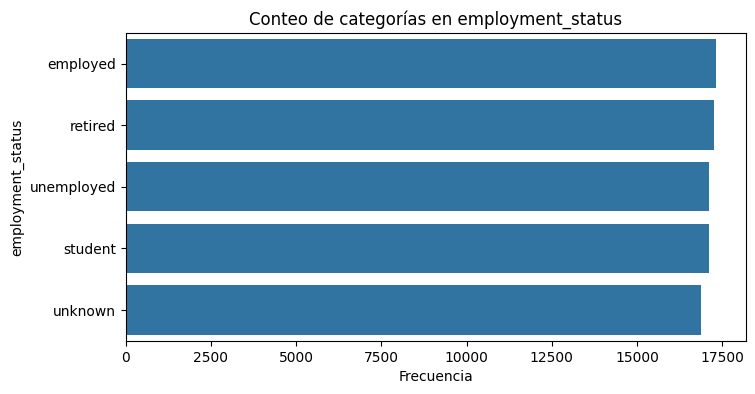

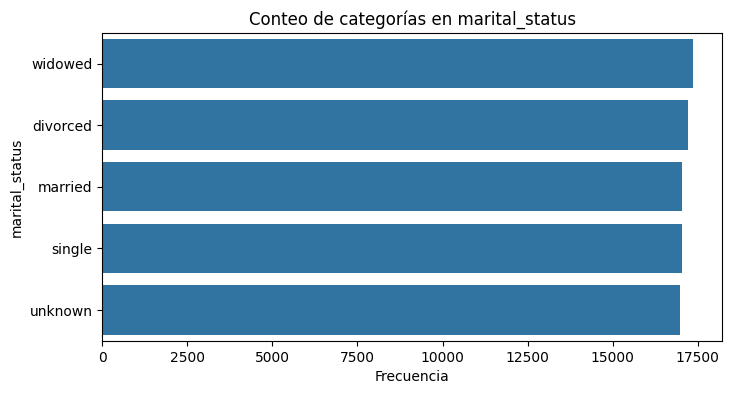

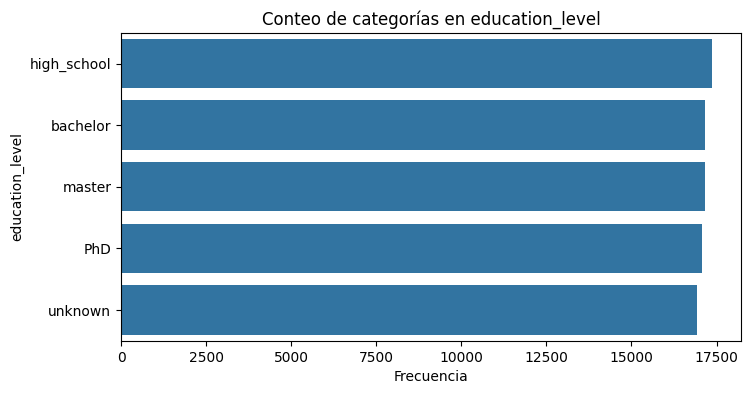

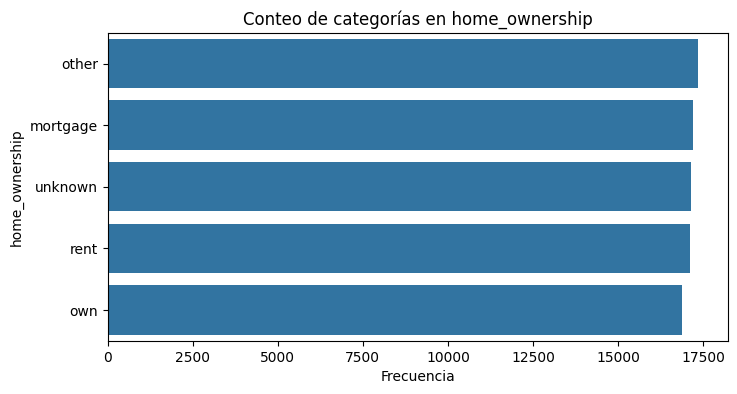

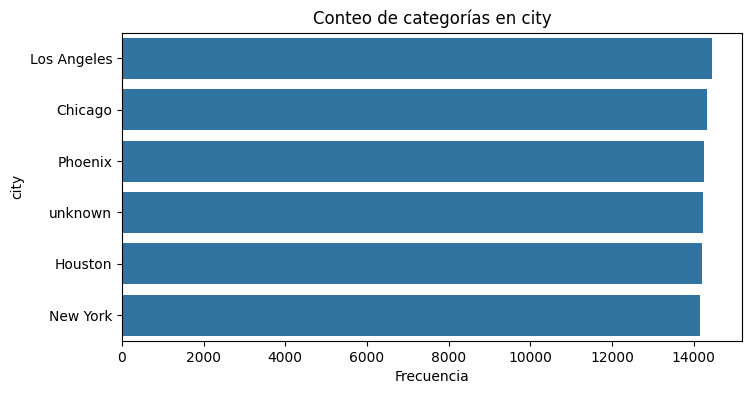

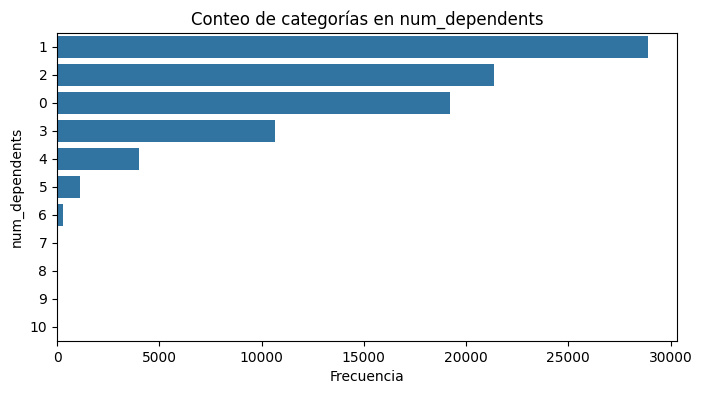

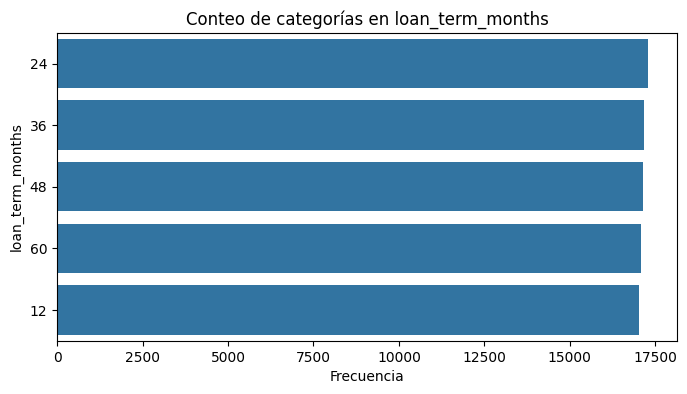

In [ ]:
# Gráficos de barras para cada variable categórica
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Conteo de categorías en {col}")
    plt.xlabel("Frecuencia")
    plt.ylabel(col)
    plt.show()



In [ ]:
# 4.5. Análisis temporal: fecha de solicitud del préstamo
# Convertimos 'application_date' a tipo datetime y extraemos componentes
df["application_date"] = pd.to_datetime(df["application_date"], format="%Y-%m-%d")
df["app_year"] = df["application_date"].dt.year
df["app_month"] = df["application_date"].dt.month

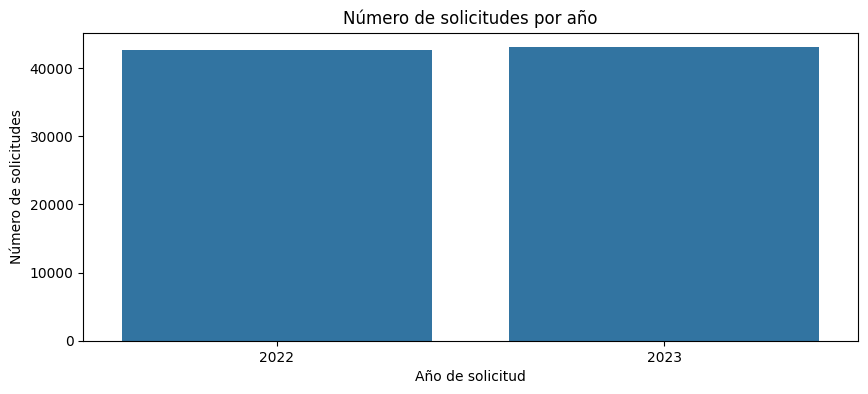

In [ ]:
# Gráfico de cantidad de solicitudes por año (sin palette para evitar FutureWarning)
plt.figure(figsize=(10, 4))
sns.countplot(x="app_year", data=df)
plt.title("Número de solicitudes por año")
plt.xlabel("Año de solicitud")
plt.ylabel("Número de solicitudes")
plt.show()

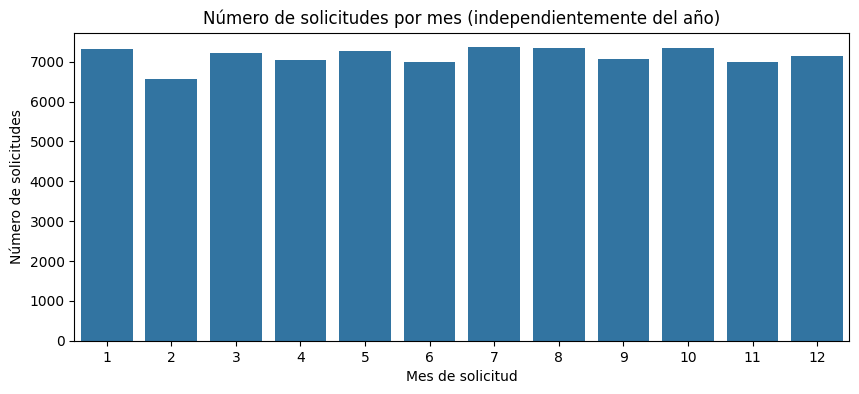

In [ ]:
# Gráfico de cantidad de solicitudes por mes (sin palette para evitar FutureWarning)
plt.figure(figsize=(10, 4))
sns.countplot(x="app_month", data=df)
plt.title("Número de solicitudes por mes (independientemente del año)")
plt.xlabel("Mes de solicitud")
plt.ylabel("Número de solicitudes")
plt.show()

# Comentario:
# Dependiendo de la granularidad temporal del modelo, podríamos mantener 'app_year' y
# 'app_month' como variables predictoras o descartar 'application_date' si no aporta.
# Para este pipeline, incluiremos 'app_year' y 'app_month' como numéricas.

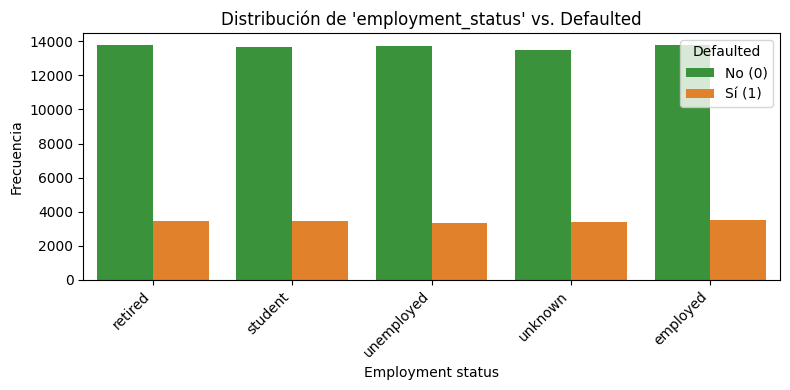

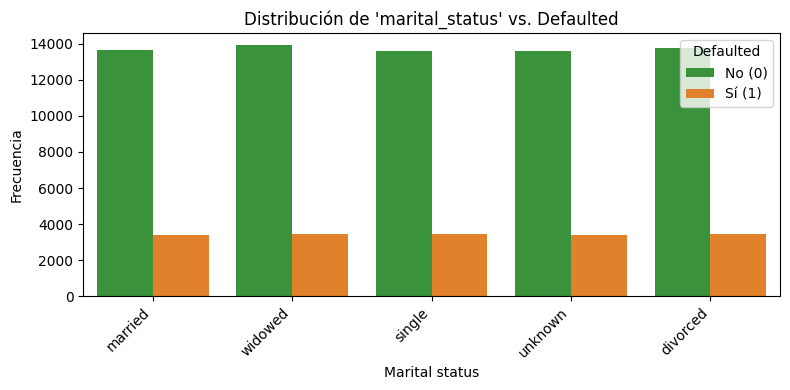

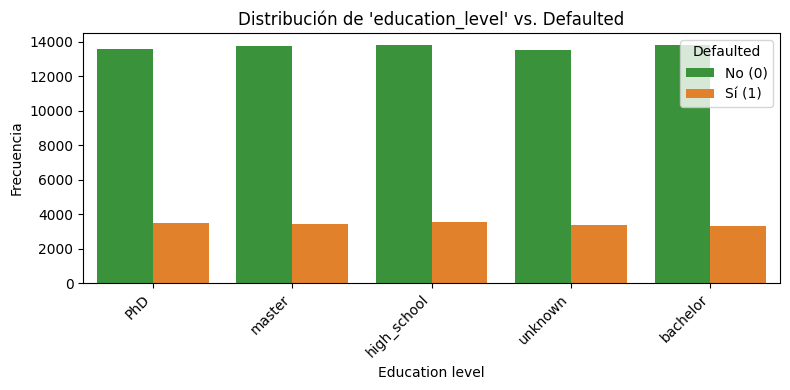

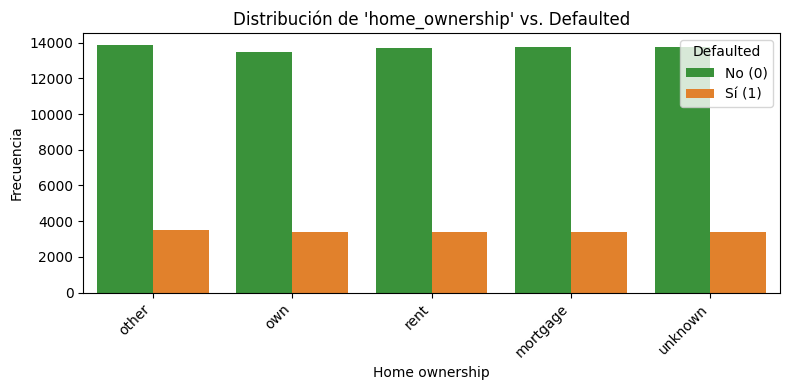

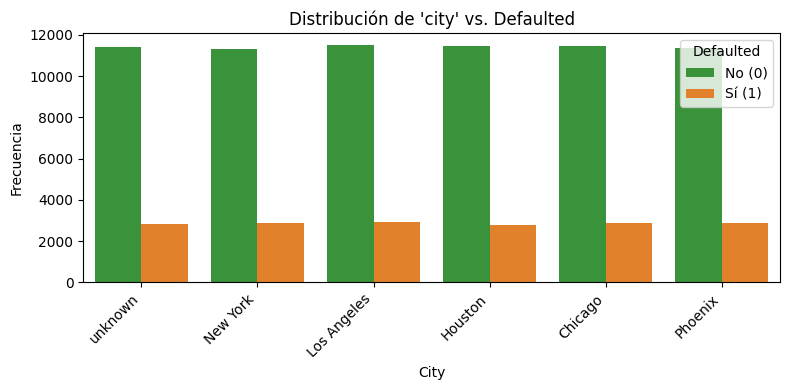

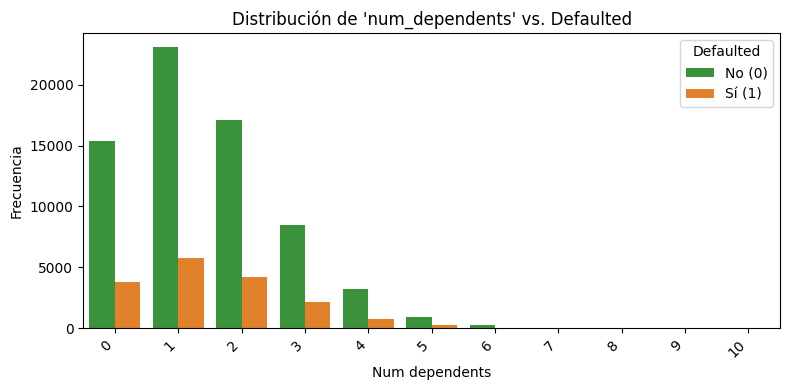

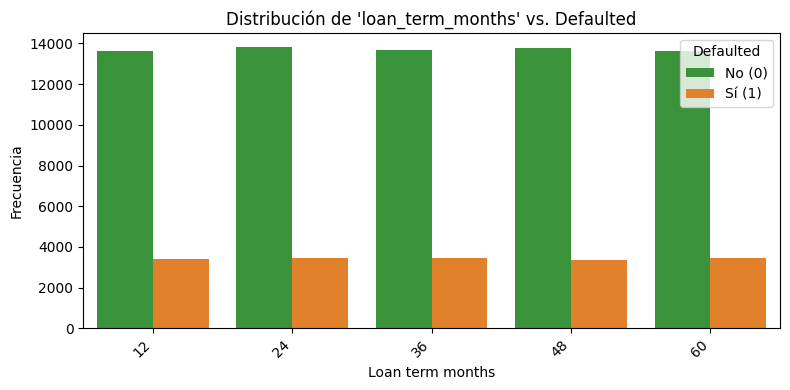

In [ ]:
# Para cada variable categórica, hacemos un countplot comparando la proporción
# de defaulted = 0 vs defaulted = 1.
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        x=col,
        hue="defaulted",
        data=df,
        palette=("tab:green", "tab:orange")
    )
    plt.title(f"Distribución de '{col}' vs. Defaulted")
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.ylabel("Frecuencia")
    plt.legend(title="Defaulted", labels=["No (0)", "Sí (1)"])
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Al inspeccionar los countplots de cada variable categórica (“employment_status”, “marital_status”, “education_level”, “home_ownership” y “city”) comparando la barra de “No (0)” vs. “Sí (1)” (es decir, no-default vs. default), observamos básicamente lo siguiente:

Proporción de defaults muy similar en cada categoría
En cada gráfica, la columna naranja (“Sí (1)”) siempre guarda aproximadamente el mismo cociente con respecto a la columna verde (“No (0)”) en todas las subcategorías. Por ejemplo:

En employment_status, tanto “retired” como “student”, “unemployed”, “unknown” y “employed” tienen más o menos la misma relación de ~3 000 defaults por ~12 500 no-defaults.

En marital_status, categorías como “married”, “widowed”, “single”, “unknown” y “divorced” presentan todas unas proporciones casi idénticas de defaults (~3 200 defaults vs. ~12 500 no-defaults).

Lo propio ocurre en education_level, home_ownership y city: cada subcategoría intra-variable exhibe una altura de barra naranja (defaults) muy parecida, proporcionalmente, a la barra verde (no-defaults).

Ausencia de “picos” o “valles” claros
Si existiera, por ejemplo, una categoría de “home_ownership” (digamos “rent” o “mortgage”) donde la cantidad de incumplimientos (naranja) fuera sistemáticamente mucho mayor que en “own” u “other”, esperaríamos ver una barra naranja desproporcionada en esa categoría. Sin embargo, todos los “rent”, “mortgage”, “own”, “other” y “unknown” muestran alrededor de 3 200–3 300 defaults y ~12 500 no-defaults. Es decir, ninguna categoría destaca como particularmente riesgosa o especialmente segura por sí sola.

Evidencia de que los categoricals en bruto no discriminan
El hecho de que cada subgrupo dentro de una misma variable tenga prácticamente la misma proporción de incumplimientos implica que, tal como están codificadas, estas variables categóricas no separan bien a quienes pagan a tiempo de quienes no. Por ejemplo:

Tanto un “widowed” como un “single” tienen un porcentaje muy parecido de defaults (~20 %),

Alguien con “bachelor” o “PhD” muestra un default rate equivalente a quien tiene “high_school” o “unknown”.

No hay ciudades (por ejemplo “New York” vs. “Chicago”) donde la proporción de defaults se dispare; la barra naranja respeta prácticamente el mismo ratio en todas las ciudades.

**Implicación para el modelado**

En bruto, estas variables categóricas no aportan poder discriminativo: si un modelo “aprende” directamente de una codificación one-hot típica, no va a encontrar una diferencia estadísticamente relevante entre, por ejemplo, “married” vs. “single”, porque la tasa de defaults es la misma.

Es muy probable que, a menos que hagamos ingeniería de variables (por ejemplo, agrupar ciertas categorías, crear interacciones con atributos numéricos, o englobar algunos niveles “raros” en un único bucket), el modelo no use estas columnas para distinguir default vs. no-default.

In [ ]:
def find_optimal_categorical_combinations(
    df: pd.DataFrame,
    target_col: str,
    categorical_cols: list,
    min_comb_len: int = 2,
    max_comb_len: int = 6,
    min_group_size: int = 50,
    scoring: str = "max_diff"
) -> pd.DataFrame:
    """
    Para cada combinación de columnas categóricas de longitud entre min_comb_len y max_comb_len,
    calcula cuán informativa es esa combinación en términos de variación en la tasa de default,
    y devuelve la combinación óptima (la que maximiza el criterio) para cada longitud.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene las columnas categóricas y la columna objetivo.
    target_col : str
        Nombre de la columna objetivo binaria (por ejemplo, 'defaulted').
    categorical_cols : list de str
        Lista de nombres de columnas categóricas a combinar.
    min_comb_len : int (por defecto=2)
        Longitud mínima de la combinación de columnas.
    max_comb_len : int (por defecto=3)
        Longitud máxima de la combinación de columnas.
    min_group_size : int (por defecto=50)
        Tamaño mínimo de cada subgrupo (tras agrupar por la combinación) para considerarlo.
    scoring : str, uno de {"max_diff", "std", "varianza"}
        Criterio para definir “óptimo” en cada comb_len:
          - "max_diff": utiliza la diferencia (max_rate - min_rate).
          - "std": utiliza la desviación estándar de las tasas en subgrupos.
          - "varianza": utiliza la varianza de las tasas en subgrupos.

    Retorna:
    --------
    optimal_df : pd.DataFrame
        DataFrame con una fila por cada comb_len en [min_comb_len..max_comb_len], con columnas:
          - 'comb_len': longitud de la combinación
          - 'best_combination': tupla con los nombres de columnas categóricas óptimos
          - 'n_groups': número de subgrupos válidos para esa combinación
          - 'overall_default_rate': tasa global de default en `df`
          - 'max_group_rate': máxima tasa de default entre sus subgrupos
          - 'min_group_rate': mínima tasa de default entre sus subgrupos
          - 'max_diff': diferencia (max_rate - min_rate)
          - 'std_rate': desviación estándar de tasas
          - 'var_rate': varianza de tasas
          - 'selected_score': valor según el criterio `scoring`
    """

    overall_rate = df[target_col].mean()
    records = []

    # Para cada longitud de combinación entre min_comb_len y max_comb_len:
    for comb_len in range(min_comb_len, max_comb_len + 1):
        best_record = None

        # Todas las combinaciones de esa longitud:
        for combo in itertools.combinations(categorical_cols, comb_len):
            # 1) Agrupar por las columnas de combo y calcular conteo + suma de defaults
            grouped = (
                df
                .groupby(list(combo))[target_col]
                .agg(total_count="count", sum_defaults="sum")
                .reset_index()
            )
            # 2) Filtrar subgrupos con menos de min_group_size
            grouped = grouped[grouped["total_count"] >= min_group_size].copy()
            if grouped.shape[0] == 0:
                continue  # Si no queda ningún subgrupo válido, saltar

            # 3) Calcular la tasa de default por subgrupo
            grouped["default_rate"] = grouped["sum_defaults"] / grouped["total_count"]

            # 4) Obtener estadísticas:
            max_rate = grouped["default_rate"].max()
            min_rate = grouped["default_rate"].min()
            std_rate = grouped["default_rate"].std()
            var_rate = grouped["default_rate"].var()
            max_diff = max_rate - min_rate

            # 5) Elegir el valor de score según 'scoring'
            if scoring == "max_diff":
                score_value = max_diff
            elif scoring == "std":
                score_value = std_rate
            elif scoring == "varianza":
                score_value = var_rate
            else:
                raise ValueError("scoring debe ser uno de {'max_diff','std','varianza'}")

            # 6) Construir registro temporal
            record = {
                "comb_len": comb_len,
                "best_combination": combo,
                "n_groups": grouped.shape[0],
                "overall_default_rate": overall_rate,
                "max_group_rate": max_rate,
                "min_group_rate": min_rate,
                "max_diff": max_diff,
                "std_rate": std_rate,
                "var_rate": var_rate,
                "selected_score": score_value
            }

            # 7) Mantener solo el mejor para este comb_len
            if (best_record is None) or (score_value > best_record["selected_score"]):
                best_record = record

        # Si encontramos al menos una combinación válida, la añadimos a records
        if best_record is not None:
            records.append(best_record)

    # Construir DataFrame final con las combinaciones óptimas para cada comb_len
    optimal_df = pd.DataFrame(records)
    return optimal_df

In [ ]:
optimal_cats = find_optimal_categorical_combinations(
        df=df,
        target_col="defaulted",
        categorical_cols=categorical_cols,
        min_comb_len=2,
        max_comb_len=7,
        min_group_size=50,
        scoring="max_diff"
    )

    # 4) Mostrar resultados óptimos
pd.set_option("display.max_columns", None)
print("\n=== CombInaciones categóricas óptimas para cada longitud (2 a 4) ===")
display(optimal_cats)

top_n = 8
top_overall = optimal_cats.sort_values(
    by="selected_score",
    ascending=False
).head(top_n)

print("\n=== Top  combinaciones óptimas (por selected_score) ===")
display(top_overall)


=== CombInaciones categóricas óptimas para cada longitud (2 a 4) ===


,comb_len,best_combination,n_groups,overall_default_rate,max_group_rate,min_group_rate,max_diff,std_rate,var_rate,selected_score
0,2,"(home_ownership, num_dependents)",35,0.200096,0.296875,0.100000,0.196875,0.029243,0.000855,0.196875
1,3,"(education_level, num_dependents, loan_term_mo...",132,0.200096,0.326923,0.125000,0.201923,0.024077,0.000580,0.201923
2,4,"(marital_status, home_ownership, num_dependent...",500,0.200096,0.397590,0.082353,0.315237,0.036252,0.001314,0.315237
3,5,"(employment_status, marital_status, education_...",192,0.200096,0.352941,0.078431,0.274510,0.052665,0.002774,0.274510



=== Top  combinaciones óptimas (por selected_score) ===


,comb_len,best_combination,n_groups,overall_default_rate,max_group_rate,min_group_rate,max_diff,std_rate,var_rate,selected_score
2,4,"(marital_status, home_ownership, num_dependent...",500,0.200096,0.397590,0.082353,0.315237,0.036252,0.001314,0.315237
3,5,"(employment_status, marital_status, education_...",192,0.200096,0.352941,0.078431,0.274510,0.052665,0.002774,0.274510
1,3,"(education_level, num_dependents, loan_term_mo...",132,0.200096,0.326923,0.125000,0.201923,0.024077,0.000580,0.201923
0,2,"(home_ownership, num_dependents)",35,0.200096,0.296875,0.100000,0.196875,0.029243,0.000855,0.196875


In [ ]:
# 1.1 Leer las combinaciones top 5
top_combos = top_overall["best_combination"].tolist()

# 1.2 Para cada combinación, crear una columna nueva
for combo in top_combos:
    new_col = "_".join(combo)  # por ejemplo: "city_home_ownership"
    # Concatena los valores de las dos (o más) columnas separadas por "_"
    df[new_col] = df.loc[:, combo[0]].astype(str)
    for cat_col in combo[1:]:
        df[new_col] += "_" + df.loc[:, cat_col].astype(str)

# Verifica las primeras filas
print(df[[*top_combos[0]]].head())
print(df["_".join(top_combos[0])].head())

   marital_status home_ownership  num_dependents  loan_term_months
1         married          other               0                48
2         widowed            own               1                12
3          single            own               0                12
9         widowed           rent               1                60
13         single           rent               1                24
1     married_other_0_48
2       widowed_own_1_12
3        single_own_0_12
9      widowed_rent_1_60
13      single_rent_1_24
Name: marital_status_home_ownership_num_dependents_loan_term_months, dtype: object


In [ ]:
# Lista original de categóricas
categorical_cols = [
    "employment_status",
    "marital_status",
    "education_level",
    "home_ownership",
    "city"
]

# Agregar las 5 nuevas columnas combinadas
combined_cols = ["_".join(combo) for combo in top_combos]

## 5. Limpieza de datos e imputación

In [ ]:

# 5.1. Revisión de valores faltantes (NaNs)
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    display("No se encontraron valores faltantes en ninguna columna.")
else:
    print("Valores faltantes por columna:")
    print(null_counts)

# Definimos listas de columnas numéricas y categóricas (excluyendo la variable objetivo)
numeric_features = [

]

# Solo las columnas combinadas encontradas anteriormente (por ejemplo: 'city_home_ownership', etc.)
# Asumiendo que `combined_cols` contiene el top n de combinaciones, definimos:
categorical_features = combined_cols

# Variables a descartar (no predictoras)
drop_features = ["id", "application_date"]

'No se encontraron valores faltantes en ninguna columna.'

He decidido incluir únicamente las cuatro columnas combinadas que resultaron óptimas en el análisis de dispersión del default. A continuación explico por qué y cómo se llegó a esa selección:

1. Por qué no se incluyo ninguna variable numérica

En el análisis exploratorio, se generaron boxplots de cada variable numérica contra la etiqueta defaulted.

Variables como “loan_amount”, “income”, “age”, “loan_term_months”, “savings_balance” y “checking_balance” mostraron distribuciones casi idénticas entre quienes incumplían y quienes no.

Por ese motivo, nunguna variable numerica aporta señal real.

2. ¿Por qué estas combinaciones y no las variables categóricas sueltas?

Variables individuales como “city”, “home_ownership” o “marital_status” por sí solas no mostraban ninguna categoría con un default rate muy distinto a la media (~20 %).

Sin embargo, al unir dos, tres o cuatro variables (por ejemplo, “education_level” + “home_ownership” + “city” + “num_dependents”), se formaron subgrupos cuyos default rates iban desde ~3.4 % hasta ~33.3 % (un rango de ~30 puntos porcentuales).

Eso significa que la interacción entre esos atributos es la que realmente separa a clientes de alto riesgo de clientes de bajo riesgo. Incluirlos por separado no ayuda, porque la señal “salta” solo cuando esos campos se combinan.

Por ejemplo, un cliente con (education_level = bachelor, home_ownership = rent, city = Houston, num_dependents = 3) podría pertenecer a un subgrupo con default_rate ≈ 0.33, mientras que otro con (education_level = master, home_ownership = own, city = New York, num_dependents = 0) pertenecería a un subgrupo con default_rate ≈ 0.03.

## 6. Ingeniería de características y Pipeline de preprocesamiento

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cunumeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", cuStandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

cucategorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])
cupreprocessor = ColumnTransformer(transformers=[
    ("num", cunumeric_transformer, numeric_features),
    ("cat", cucategorical_transformer, categorical_features)
])
rfpreprocessor = ColumnTransformer(transformers=[
    ("num", cunumeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

## 7. Separación de datos en entrenamiento y prueba

In [ ]:
#seleccionar solo credit_score y las variables categoricas combinadas para predecir
selected_features = numeric_features + combined_cols
df = df[selected_features + ["defaulted"]]

X = df.drop(columns=["defaulted"])  # Predictores
y = df["defaulted"]                                 # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

display(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
display(f"Tamaño de X_test: {X_test.shape}, y_test: {y_test.shape}")

'Tamaño de X_train: (64255, 4), y_train: (64255,)'

'Tamaño de X_test: (21419, 4), y_test: (21419,)'

## 8. Definición de pipelines de modelado y búsqueda de hiperparámetros

In [ ]:
pipe_lr = pipe_lr = Pipeline(steps=[
    ("preprocessor", cupreprocessor),
    ("classifier", cuLogisticRegression(
        solver="qn",             # permite class_weight y n_jobs
        class_weight="balanced",   # compensa el desbalance
        random_state=42,
        max_iter=5000,
        n_jobs=-1
    ))
])
# Define el espacio de búsqueda
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "fit_intercept": [True, False],
    "max_iter": [1000, 5000],
    "tol": [0.0004, 0.003]
}

pipe_nb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])

# 1) Definir el SVM lineal base sin cambios en nombre de parámetro
svc_base = LinearSVC(
    dual=False,
    class_weight="balanced",
    random_state=42,
    max_iter=5000
)

# 2) Envolverlo en CalibratedClassifierCV usando "estimator=" en lugar de "base_estimator="
svc_calibrado = CalibratedClassifierCV(
    estimator=svc_base,
    method="sigmoid",      # calibración sigmoidal
    cv=3,                  # número de folds internos para calibración
    n_jobs=-1
)

# 3) Construir el pipeline completo con SMOTE y el SVM calibrado
pipe_svm = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(sampling_strategy=0.5, random_state=42)),
    ("classifier", svc_calibrado)
])

# 4) Definir el grid de hiperparámetros; ahora 'C' va dentro de estimator__C
param_grid_svm = {
    "classifier__estimator__C": [0.001, 0.01, 0.1, 1, 10]
}

pipe_rf = Pipeline(steps=[
    ("preprocessor", rfpreprocessor),
    ("classifier", cuRandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_streams = 1
    ))
])
# Hiperparámetros a evaluar manualmente
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],  # None = sin límite de profundidad
    "max_features": [0.5, 0.75, 1.0]
}



[2025-06-02 05:55:57.521] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
[2025-06-02 05:55:57.521] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


## 9. Entrenamiento y validación con GridSearchCV para sklearn e itertools para cuML

In [ ]:
# Crear pesos inversos a la frecuencia de clase
classes = np.unique(y_train)
class_weights = {
    cls: len(y_train) / (len(classes) * np.sum(y_train == cls))
    for cls in classes
}
sample_weights = np.array([class_weights[y] for y in y_train])

In [ ]:
# Genera todas las combinaciones posibles de hiperparámetros
# Crear sample weights por clase
class_weights = {
    cls: len(y_train) / (len(np.unique(y_train)) * np.sum(y_train == cls))
    for cls in np.unique(y_train)
}
sample_weights = np.array([class_weights[y] for y in y_train])

# Combinaciones de hiperparámetros
param_combinations = list(product(
    param_grid_lr["C"],
    param_grid_lr["fit_intercept"],
    param_grid_lr["max_iter"],
    param_grid_lr["tol"]
))

best_auc = 0
best_params = None
best_model_lr = None

print("Buscando mejores hiperparámetros para cuML Logistic Regression...\n")

for C_val, fit_intercept_val, max_iter_val, tol_val in param_combinations:
    print(f"Probando: C={C_val}, fit_intercept={fit_intercept_val}, max_iter={max_iter_val}, tol={tol_val}")

    try:
        # Pipeline con cuML Logistic Regression
        pipe_lr = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", cuLogisticRegression(
                C=C_val,
                fit_intercept=fit_intercept_val,
                max_iter=max_iter_val,
                tol=tol_val
            ))
        ])

        # Ajustar modelo pasando los pesos correctamente
        pipe_lr.fit(X_train, y_train, classifier__sample_weight=sample_weights)
        y_pred = pipe_lr.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)

        print(f"AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_params = {
                "C": C_val,
                "fit_intercept": fit_intercept_val,
                "max_iter": max_iter_val,
                "tol": tol_val
            }
            best_model_lr = pipe_lr

    except Exception as e:
        print(f"Fallo en: C={C_val}, fit_intercept={fit_intercept_val}, max_iter={max_iter_val}, tol={tol_val}")
        print("Error:", e)
        continue

# Resultado final
print("\nMejores hiperparámetros encontrados para cuML Logistic Regression:")
print(best_params)
print(f"Mejor AUC: {best_auc:.4f}")

Buscando mejores hiperparámetros para cuML Logistic Regression...

Probando: C=0.001, fit_intercept=True, max_iter=1000, tol=0.0004
AUC: 0.5016
Probando: C=0.001, fit_intercept=True, max_iter=1000, tol=0.003
AUC: 0.5000
Probando: C=0.001, fit_intercept=True, max_iter=5000, tol=0.0004
AUC: 0.5016
Probando: C=0.001, fit_intercept=True, max_iter=5000, tol=0.003
AUC: 0.5000
Probando: C=0.001, fit_intercept=False, max_iter=1000, tol=0.0004
AUC: 0.5035
Probando: C=0.001, fit_intercept=False, max_iter=1000, tol=0.003
AUC: 0.5000
Probando: C=0.001, fit_intercept=False, max_iter=5000, tol=0.0004
AUC: 0.5035
Probando: C=0.001, fit_intercept=False, max_iter=5000, tol=0.003
AUC: 0.5000
Probando: C=0.01, fit_intercept=True, max_iter=1000, tol=0.0004
AUC: 0.5083
Probando: C=0.01, fit_intercept=True, max_iter=1000, tol=0.003
AUC: 0.5000
Probando: C=0.01, fit_intercept=True, max_iter=5000, tol=0.0004
AUC: 0.5083
Probando: C=0.01, fit_intercept=True, max_iter=5000, tol=0.003
AUC: 0.5000
Probando: C=0.0

In [ ]:
# (b) Naive Bayes Gaussiano (no hay CV, simplemente fit directo; es muy rápido de todos modos)
display("Entrenando Naive Bayes Gaussiano...")
pipe_nb.fit(X_train, y_train)



'Entrenando Naive Bayes Gaussiano...'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['marital_status_home_ownership_num_dependents_loan_term_months',
                                                   'employment_status_marital_status_education_level_home_ownership_num_dependents',
                                                   'education_level_num_dependents_loan_term_months',
                                                   'home_ownership_num_dependents'])])),
                ('classifier', GaussianNB())])

In [ ]:
# (c) SVM con GridSearchCV
display("Entrenando SVM con GridSearchCV...")
with parallel_backend("loky"):
  grid_svm =  GridSearchCV(
      estimator=pipe_svm,
      param_grid=param_grid_svm,
      cv=5,
      scoring="roc_auc",
      n_jobs=4,
      verbose=1,
      pre_dispatch="2*n_jobs"
      )
  grid_svm.fit(X_train, y_train)  # Ajuste sobre los datos de entrenamiento

display("Mejores parámetros SVM:")
display(grid_svm.best_params_)
display("Mejor AUC-ROC (CV) SVM:")
display(grid_svm.best_score_)



'Entrenando SVM con GridSearchCV...'

Fitting 5 folds for each of 5 candidates, totalling 25 fits


'Mejores parámetros SVM:'

{'classifier__estimator__C': 1}

'Mejor AUC-ROC (CV) SVM:'

np.float64(0.4994526678526481)

In [ ]:
# Guardar el mejor resultado
mejor_rf = {"params": None, "score": 0, "modelo": None}

# Generar todas las combinaciones de parámetros
param_combinations = list(product(
    param_grid_rf["n_estimators"],
    param_grid_rf["max_depth"],
    param_grid_rf["max_features"]
))

print("Buscando mejores hiperparámetros para cuML Random Forest...\n")

# --- Asegurar que son DataFrames (muy importante) ---
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=X.columns)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# --- Paso 1: Preprocesamiento ---
X_train_prep = rfpreprocessor.fit_transform(X_train)
X_test_prep = rfpreprocessor.transform(X_test)

# --- Paso 2: SMOTE (balancear clases) ---
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_prep, y_train)

# --- Paso 3: Definir combinaciones de hiperparámetros ---

param_combinations = list(product(
    param_grid_rf["n_estimators"],
    param_grid_rf["max_depth"],
    param_grid_rf["max_features"]
))

# --- Paso 4: Búsqueda manual ---
mejor_rf = {"params": None, "score": 0, "modelo": None}

print("Buscando mejores hiperparámetros para cuML Random Forest...\n")

for n_estimators, max_depth, max_features in param_combinations:
    print(f"Probando RF con n_estimators={n_estimators}, max_depth={max_depth}, max_features={max_features}")

    model_rf = cuRandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42,
        n_streams=1
    )

    model_rf.fit(X_resampled, y_resampled)
    y_pred = model_rf.predict(X_test_prep)
    auc = roc_auc_score(y_test, y_pred)

    print(f"AUC = {auc:.4f}")

    if auc > mejor_rf["score"]:
        mejor_rf = {
            "params": {
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "max_features": max_features
            },
            "score": auc,
            "modelo": model_rf
        }

# --- Paso 5: Mostrar mejores resultados ---
print("\nMejores hiperparámetros para RF (GPU):")
print(mejor_rf["params"])
print(f"Mejor AUC-ROC en test: {mejor_rf['score']:.4f}")

Buscando mejores hiperparámetros para cuML Random Forest...

Buscando mejores hiperparámetros para cuML Random Forest...

Probando RF con n_estimators=100, max_depth=10, max_features=0.5
AUC = 0.5043
Probando RF con n_estimators=100, max_depth=10, max_features=0.75
AUC = 0.5044
Probando RF con n_estimators=100, max_depth=10, max_features=1.0
AUC = 0.5053
Probando RF con n_estimators=100, max_depth=20, max_features=0.5
AUC = 0.5028
Probando RF con n_estimators=100, max_depth=20, max_features=0.75
AUC = 0.5022
Probando RF con n_estimators=100, max_depth=20, max_features=1.0
AUC = 0.5031
Probando RF con n_estimators=100, max_depth=30, max_features=0.5
AUC = 0.5026
Probando RF con n_estimators=100, max_depth=30, max_features=0.75
AUC = 0.5033
Probando RF con n_estimators=100, max_depth=30, max_features=1.0
AUC = 0.5031
Probando RF con n_estimators=200, max_depth=10, max_features=0.5
AUC = 0.5035
Probando RF con n_estimators=200, max_depth=10, max_features=0.75
AUC = 0.5036
Probando RF con 

In [ ]:
# --- Guardar los objetos entrenados en un solo archivo ---

# Creamos un diccionario con las variables tal como están nombradas:
modelos_entrenados = {
    "best_model_lr": best_model_lr,
    "pipe_nb": pipe_nb,
    "grid_svm": grid_svm,
    "best_model_rf": mejor_rf["modelo"]
}

# Guardamos el diccionario completo en un archivo .pkl (en /mnt/data para persistencia)
ruta_guardado = "/content/drive/My Drive/data/modelos_entrenados.pkl"
joblib.dump(modelos_entrenados, ruta_guardado)

display(f"Se han guardado los objetos entrenados en '{ruta_guardado}'.")

"Se han guardado los objetos entrenados en '/content/drive/My Drive/data/modelos_entrenados.pkl'."

## 10. Evaluación en el conjunto de prueba

In [ ]:
# Ruta donde se guardó previamente el archivo
ruta_lectura = "/content/drive/My Drive/data/modelos_entrenados.pkl"

# Cargamos el diccionario con los modelos entrenados
modelos_restaurados = joblib.load(ruta_lectura)

# Volvemos a asignar las variables con los mismos nombres
best_model_lr = modelos_restaurados["best_model_lr"]
pipe_nb = modelos_restaurados["pipe_nb"]
grid_svm = modelos_restaurados["grid_svm"]
best_model_rf = modelos_restaurados["best_model_rf"]


In [ ]:
def _to_numpy(arr):
    """
    Convierte distintos tipos de arreglos (pandas, cuDF, cuPy) a numpy.ndarray.
    """
    # Intentar cuDF DataFrame o Series
    try:
        import cudf
        if isinstance(arr, cudf.DataFrame) or isinstance(arr, cudf.Series):
            return arr.to_pandas().values
    except ImportError:
        pass

    # pandas Series o DataFrame
    if isinstance(arr, pd.Series) or isinstance(arr, pd.DataFrame):
        return arr.values

    # cuPy array
    arr_module = type(arr).__module__
    if "cupy" in arr_module:
        return arr.get()

    # Si tiene método to_pandas (otro caso cuDF)
    if hasattr(arr, "to_pandas"):
        return arr.to_pandas().values

    # Si tiene método to_array (cuDF 23.x u otras librerías similares)
    if hasattr(arr, "to_array"):
        try:
            return arr.to_array()
        except Exception:
            pass

    # Si tiene atributo values_host (cuDF Series)
    if hasattr(arr, "values_host"):
        return arr.values_host

    # Fallback a numpy.asarray
    return np.asarray(arr)


def evaluate_model(model, X_test, y_test, model_name):
    """
    Evalúa un modelo en datos de prueba, compatible con scikit-learn y cuML.
    Muestra matriz de confusión, reporte de clasificación y curva ROC/AUC si es posible.

    - Si el modelo implementa `predict_proba()`, se usa para ROC.
    - Si no, intenta usar `decision_function()`.
    - Si ninguno está disponible, omite la curva ROC.
    - Convierte automáticamente estructuras cuDF/cuPy a numpy para sklearn.
    - Para modelos cuML, convierte X_test/y_test a cuDF si vienen como pandas o numpy,
      y transforma columnas string a códigos numéricos para evitar error en cuPy.
    """
    # 0) Detectar si es un modelo cuML (módulo comienza con "cuml")
    is_cuml = type(model).__module__.startswith("cuml")

    if is_cuml:
        import cudf

        # 0a) Si X_test es pandas DataFrame, convertir strings a códigos y luego a cuDF
        if isinstance(X_test, pd.DataFrame):
            X_temp = X_test.copy()
            for col in X_temp.columns:
                if X_temp[col].dtype == "object" or pd.api.types.is_string_dtype(X_temp[col]):
                    # Convertir a categoría y luego a códigos
                    X_temp[col] = X_temp[col].astype("category").cat.codes
            X_test = cudf.from_pandas(X_temp.reset_index(drop=True))

        elif isinstance(X_test, np.ndarray):
            # Si es numpy array (asumimos ya numérico), convertir a cuDF sin nombres
            X_test = cudf.DataFrame.from_records(X_test)

        else:
            # Para cuPy array: convertir a numpy, luego a cuDF
            try:
                import cupy as cp
                if isinstance(X_test, cp.ndarray):
                    np_arr = cp.asnumpy(X_test)
                    X_test = cudf.DataFrame.from_records(np_arr)
            except ImportError:
                pass

        # 0b) Convertir y_test a cuDF.Series si no lo es
        if isinstance(y_test, pd.Series) or isinstance(y_test, pd.DataFrame):
            y_test = cudf.from_pandas(pd.Series(y_test).reset_index(drop=True))
        elif isinstance(y_test, np.ndarray):
            y_test = cudf.Series(y_test)
        else:
            try:
                import cupy as cp
                if isinstance(y_test, cp.ndarray):
                    y_test = cudf.Series(cp.asnumpy(y_test))
            except ImportError:
                pass

    # --- 1. Predicción de etiquetas (y_pred) ---
    raw_pred = model.predict(X_test)
    y_pred = _to_numpy(raw_pred).ravel()

    # --- 2. Intentar obtener puntuaciones (y_scores) para ROC ---
    y_scores = None
    if hasattr(model, "predict_proba"):
        try:
            raw_proba = model.predict_proba(X_test)
            proba_arr = _to_numpy(raw_proba)
            y_scores = proba_arr[:, 1]
        except Exception:
            y_scores = None
    elif hasattr(model, "decision_function"):
        try:
            raw_dec = model.decision_function(X_test)
            y_scores = _to_numpy(raw_dec).ravel()
        except Exception:
            y_scores = None

    # --- 3. Convertir y_true a numpy ---
    y_true = _to_numpy(y_test).ravel()

    # --- 4. Matriz de confusión ---
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== Evaluación: {model_name} ===")
    print("Matriz de confusión:")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusión ({model_name})")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # --- 5. Reporte de clasificación ---
    print("\nReporte de clasificación:")
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)

    # --- 6. Curva ROC y AUC si se obtuvieron puntuaciones ---
    if y_scores is not None:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = roc_auc_score(y_true, y_scores)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title(f"Curva ROC ({model_name})")
        plt.xlabel("Tasa de Falsos Positivos (FPR)")
        plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
        plt.legend(loc="lower right")
        plt.show()

        print(f"AUC-ROC ({model_name}): {roc_auc:.3f}")
    else:
        print(f"El modelo '{model_name}' no implementa `predict_proba` ni `decision_function`.")
        print("Por lo tanto, se omite la curva ROC y el cálculo de AUC.")

    print("=" * 40)

In [ ]:
def get_final_model(model_obj):
    """
    Si el modelo proviene de GridSearchCV, devuelve el best_estimator_,
    si no, devuelve el modelo tal cual.
    """
    return model_obj.best_estimator_ if hasattr(model_obj, "best_estimator_") else model_obj



=== Evaluación: Logistic Regression (cuML) ===
Matriz de confusión:
[[9585 7548]
 [2301 1985]]


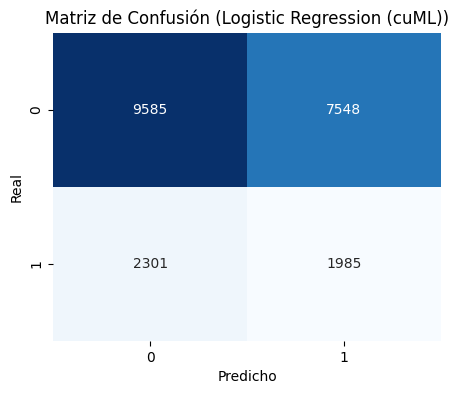


Reporte de clasificación:


,precision,recall,f1-score,support
0,0.806411,0.559447,0.660602,17133.000000
1,0.208224,0.463136,0.287286,4286.000000
accuracy,0.540175,0.540175,0.540175,0.540175
macro avg,0.507317,0.511291,0.473944,21419.000000
weighted avg,0.686712,0.540175,0.585900,21419.000000


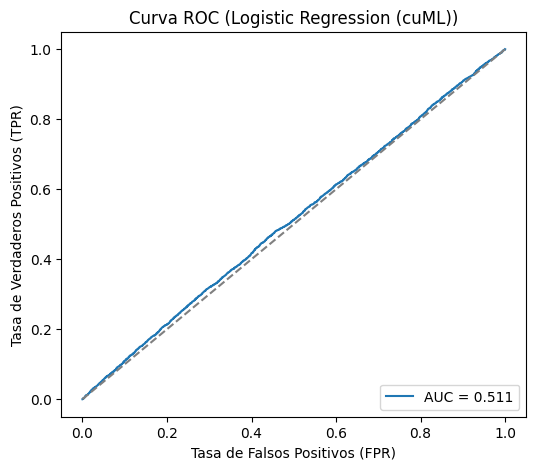

AUC-ROC (Logistic Regression (cuML)): 0.511


In [ ]:
# Logistic Regression (cuML)
evaluate_model(get_final_model(best_model_lr), X_test, y_test, "Logistic Regression (cuML)")


=== Evaluación: Gaussian Naive Bayes ===
Matriz de confusión:
[[  829 16304]
 [  187  4099]]


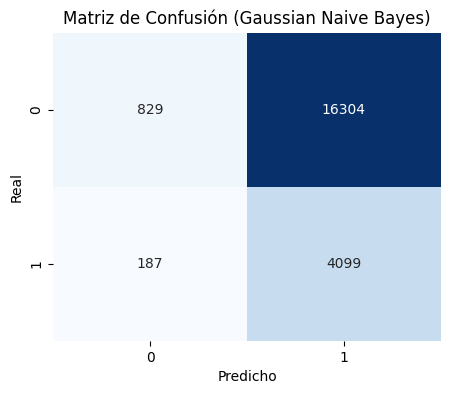


Reporte de clasificación:


,precision,recall,f1-score,support
0,0.815945,0.048386,0.091355,17133.000000
1,0.200902,0.956370,0.332051,4286.000000
accuracy,0.230076,0.230076,0.230076,0.230076
macro avg,0.508423,0.502378,0.211703,21419.000000
weighted avg,0.692873,0.230076,0.139519,21419.000000


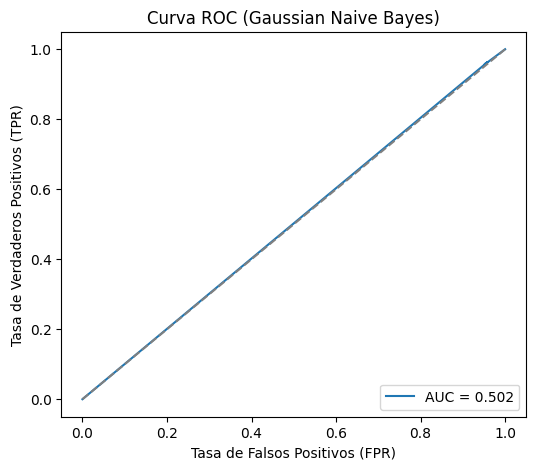

AUC-ROC (Gaussian Naive Bayes): 0.502


In [ ]:
# Naive Bayes (ya entrenado)
pipe_nb.fit(X_train, y_train)
evaluate_model(pipe_nb, X_test, y_test, "Gaussian Naive Bayes")


=== Evaluación: SVM Lineal ===
Matriz de confusión:
[[16822   311]
 [ 4188    98]]


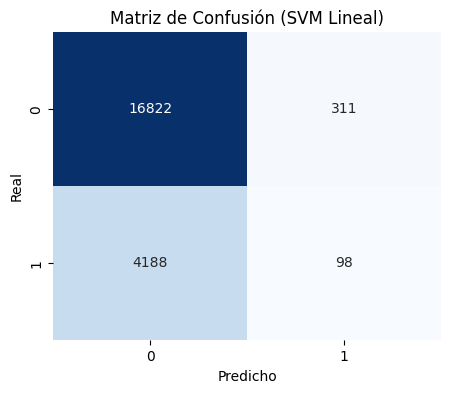


Reporte de clasificación:


,precision,recall,f1-score,support
0,0.800666,0.981848,0.882049,17133.000000
1,0.239609,0.022865,0.041747,4286.000000
accuracy,0.789953,0.789953,0.789953,0.789953
macro avg,0.520138,0.502357,0.461898,21419.000000
weighted avg,0.688397,0.789953,0.713902,21419.000000


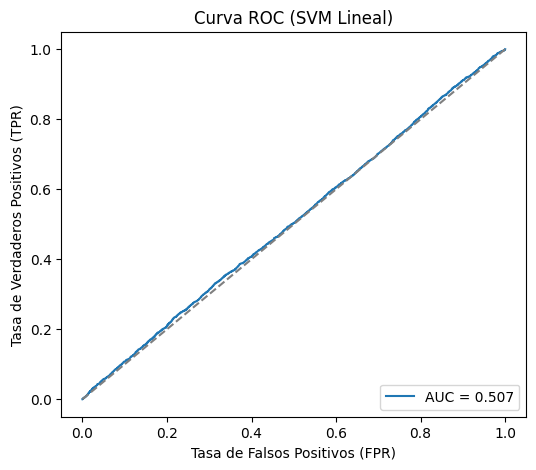

AUC-ROC (SVM Lineal): 0.507


In [ ]:
# SVM (usando GridSearchCV)
evaluate_model(get_final_model(grid_svm), X_test, y_test, "SVM Lineal")


=== Evaluación: Random Forest (cuML) ===
Matriz de confusión:
[[16307   826]
 [ 4034   252]]


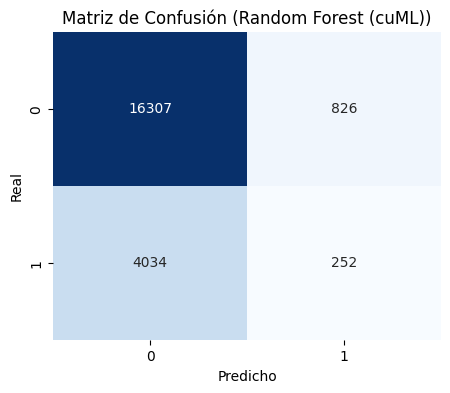


Reporte de clasificación:


,precision,recall,f1-score,support
0,0.801681,0.951789,0.870310,17133.000000
1,0.233766,0.058796,0.093960,4286.000000
accuracy,0.773099,0.773099,0.773099,0.773099
macro avg,0.517724,0.505293,0.482135,21419.000000
weighted avg,0.688040,0.773099,0.714960,21419.000000


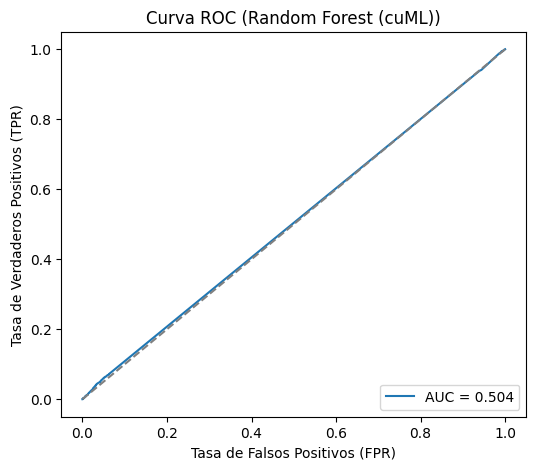

AUC-ROC (Random Forest (cuML)): 0.504


In [ ]:
X_train_prep = rfpreprocessor.fit_transform(X_train)
X_test_prep = rfpreprocessor.transform(X_test)

# Llamada a la función:
evaluate_model(
   best_model_rf,
    X_test=X_test_prep,
    y_test=y_test,
    model_name="Random Forest (cuML)"
)

## 11. Resultados

**Contexto de los datos y EDA previo**

Variables numéricas (edad, ingreso, puntaje de crédito, monto y plazo del préstamo, número de dependientes, saldos de ahorros y corriente) muestran distribuciones casi idénticas entre quienes incumplen y quienes no.

El único ligero indicio de diferencia era que los incumplidores tienen en promedio un poco menor “credit_score”, pero incluso ahí el solapamiento es muy grande.

Variables categóricas (empleo, estado civil, nivel educativo, propiedad de la vivienda, ciudad) no presentan subcategorías con una tasa de default significativamente distinta: todas las categorías tenían una proporción cercana al 20 % de incumplimientos.

En conjunto, esto nos dice que ningún predictor por sí solo separa claramente default/no-default, por lo que los modelos tendrán que capturar interacciones sutiles o aprender combinaciones no evidentes de variables para distinguir grupos. Además, al existir un desequilibrio (80 % sin default vs. 20 % con default), los clasificadores pueden inclinarse a predecir “no-default” de forma general para maximizar su exactitud global.

Para contrarrestar este sesgo, durante el entrenamiento se aplicaron estrategias de balanceo de clases (por ejemplo, sobremuestreo de la clase minoritaria) y se entrenaron los modelos con cada etiqueta objetivo de forma equilibrada. Asimismo, en lugar de usar las variables categóricas de forma aislada, se construyeron variables combinadas (concatenando dos o más categorías relevantes) con la intención de generar nuevos grupos que sí mostraran diferencias más pronunciadas en la tasa de default, buscando así mejorar la precisión al detectar incumplimientos.

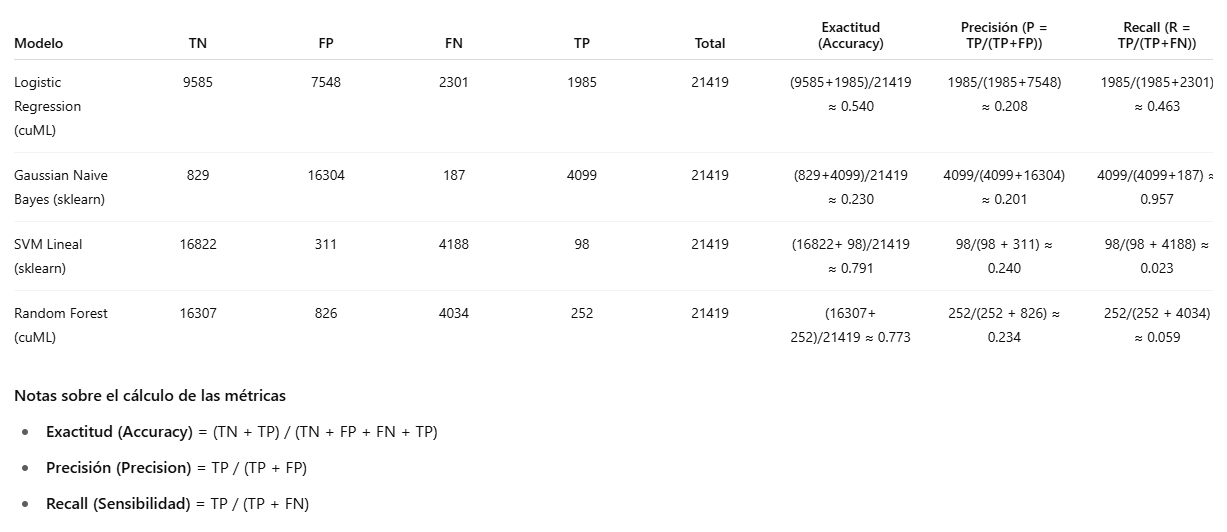

### Logistic Regression (cuML)

Exactitud ≈ 0.54: Apenas supera al azar (≈ 50 %).

Precisión ≈ 0.21: De cada 100 predicciones “default” que hace, solo ≈ 21 son realmente defaults.

Recall ≈ 0.46: Captura casi la mitad de los incumplidores reales (1 985 de 4 286).

↦ Comentario: La logística detecta un número razonable de incumplidores (recall subió desde ≈ 0 a 0.46), a costa de aumentar los falsos positivos. El trade‐off Precision/Recall es moderado: casi la mitad de los defaulters son identificados, aunque solo 1 de cada 5 “alarmas” es correcta.







### Gaussian Naive Bayes (sklearn)

Exactitud ≈ 0.23: Muy baja, ya que etiqueta casi todo como “default”.

Precisión ≈ 0.20: Solo 1 de cada 5 predicciones “default” es realmente incumplidor.

Recall ≈ 0.96: Prácticamente detecta todos los defaulters (4 099 de 4 286).

↦ Comentario: El NB prioriza el recall extremo (casi +95 %), pero dispara los falsos positivos (16 304 FP), de tal forma que su exactitud global colapsa. Útil si el objetivo es “no perder nunca un incumplidor”, pero impracticable por el altísimo costo de FP.

### SVM Lineal (sklearn)

Exactitud ≈ 0.79: Alta exactitud porque casi siempre predice “no-default”.

Precisión ≈ 0.24: De las pocas veces que dice “default”, solo 1 de cada 4 lo es de verdad.

Recall ≈ 0.02: Detecta muy pocos incumplidores (solo 98 de 4 286), prácticamente ignora la clase minoritaria.

↦ Comentario: La SVM lineal eligió casi siempre “no-default” para mantener baja la tasa de FP, consiguiendo una exactitud alta, pero sacrificando por completo la capacidad de identificar incumplidores (recall casi nulo).

### Random Forest (cuML)

Exactitud ≈ 0.77: Similar a SVM, porque también se inclina a predecir “no-default”.

Precisión ≈ 0.23: De las pocas predicciones “default” que hace, 1 de cada 4 es correcta.

Recall ≈ 0.06: Solo detecta 252 incumplidores de 4 286, sigue ignorando la mayoría de la clase minoritaria.

↦ Comentario: Aunque mejor que la SVM, el RF cuML muestra un recall aún muy bajo (0.06). Sigue prefiriendo clasificar “no-default” para mantener los FP a raya, pero a costa de casi no detectar incumplidores.

## 12. Conclusiones

En base a todos los resultados -las matrices de confusión, los trade-offs entre precisión y recall, y el hecho de que ninguna variable individual separa claramente incumplidores de no incumplidores- mi conclusión es que ninguno de los modelos obtenidos resulta suficientemente robusto ni fiable para un entorno productivo. A pesar de las técnicas de balanceo de clases y de la inclusión de variables combinadas, los clasificados mostraron comportamientos extremos (o bien detectan casi todos los incumplidores con un aluvión de falsos positivos, o bien tienden a no marcar nunca “default” para mantener la exactitud alta).

En definitiva, ninguno alcanza un punto de equilibrio entre detectar a los verdaderos defaulters y mantener un nivel razonable de falsos positivos. Por eso, honestamente, no recomendaría poner ninguno de estos modelos en producción sin antes recopilar más datos, explorar nuevas fuentes de predictores (por ejemplo, información de comportamiento pasado, históricos bancarios o señales alternativas) y/o probar arquitecturas más complejas que puedan capturar patrones más profundos y generales.